In [1]:
%pylab inline

Populating the interactive namespace from numpy and matplotlib


In [23]:
import numpy as np
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
from torch.optim.lr_scheduler import StepLR,MultiStepLR
import math
import torch.nn.functional as F
from torch.utils import data
from sklearn.model_selection import train_test_split
from torch.utils.data import Dataset
from ssc_dataset_f import my_Dataset
import os

torch.manual_seed(0)
batch_size = 32
train_dir = './data/train/'
train_files = [train_dir+i for i in os.listdir(train_dir)]
valid_dir = './data/valid/'
valid_files = [valid_dir+i for i in os.listdir(valid_dir)]
test_dir = './data/test/'
test_files = [test_dir+i for i in os.listdir(test_dir)]
train_dataset = my_Dataset(train_files)
valid_dataset = my_Dataset(valid_files)
test_dataset = my_Dataset(test_files)
train_loader = data.DataLoader(train_dataset,batch_size=batch_size,shuffle=True)#,num_workers=10)
valid_loader = data.DataLoader(valid_dataset,batch_size=batch_size,shuffle=True)#,num_workers=5)
test_loader = data.DataLoader(test_dataset,batch_size=batch_size,shuffle=True)#,num_workers=5)

'''
STEP 2: MAKING DATASET ITERABLE
'''

decay = 0.1  # neuron decay rate
thresh = 0.5  # neuronal threshold
lens = 0.5  # hyper-parameters of approximate function
num_epochs = 150  # 150  # n_iters / (len(train_dataset) / batch_size)
num_epochs = int(num_epochs)

'''
STEP 3a: CREATE spike MODEL CLASS
'''

b_j0 = 0.01  # neural threshold baseline
R_m = 1  # membrane resistance
dt = 1  #
gamma = .5  # gradient scale

gradient_type = 'MG'
print('gradient_type: ',gradient_type)
def gaussian(x, mu=0., sigma=.5):
    return torch.exp(-((x - mu) ** 2) / (2 * sigma ** 2)) / torch.sqrt(2 * torch.tensor(math.pi)) / sigma


# define approximate firing function

class ActFun_adp(torch.autograd.Function):
    @staticmethod
    def forward(ctx, input):  # input = membrane potential- threshold
        ctx.save_for_backward(input)
        return input.gt(0).float()  # is firing ???

    @staticmethod
    def backward(ctx, grad_output):  # approximate the gradients
        input, = ctx.saved_tensors
        grad_input = grad_output.clone()
        # temp = abs(input) < lens
        scale = 6.0
        hight = .15
        if gradient_type == 'G':
            temp = torch.exp(-(input**2)/(2*lens**2))/torch.sqrt(2*torch.tensor(math.pi))/lens
        elif gradient_type == 'MG':
            temp = gaussian(input, mu=0., sigma=lens) * (1. + hight) \
                - gaussian(input, mu=lens, sigma=scale * lens) * hight \
                - gaussian(input, mu=-lens, sigma=scale * lens) * hight
        elif gradient_type =='linear':
            temp = F.relu(1-input.abs())
        elif gradient_type == 'slayer':
            temp = torch.exp(-5*input.abs())
        return grad_input * temp.float() * gamma


act_fun_adp = ActFun_adp.apply


# tau_m = torch.FloatTensor([tau_m])

def mem_update_adp(inputs, mem, spike, tau_adp, b, tau_m, dt=1, isAdapt=1):
    alpha = torch.exp(-1. * dt / tau_m).cuda()
    ro = torch.exp(-1. * dt / tau_adp).cuda()
    if isAdapt:
        beta = 1.8
    else:
        beta = 0.

    b = ro * b + (1 - ro) * spike
    B = b_j0 + beta * b

    mem = mem * alpha + (1 - alpha) * R_m * inputs - B * spike * dt
    inputs_ = mem - B
    spike = act_fun_adp(inputs_)
    #spike = F.relu(inputs_)#  # act_fun : approximation firing function
    return mem, spike, B, b

# LIF neuron
def mem_update_adp1(inputs, mem, spike, tau_adp, b, tau_m, dt=1, isAdapt=1):

    b = 0
    B = .5
    alpha = torch.exp(-1. * dt / tau_adp).cuda()
    mem = mem * .7 + inputs#(1-alpha)*inputs
    inputs_ = mem - B
    spike = act_fun_adp(inputs_)  # act_fun : approximation firing function
    mem = (1-spike)*mem 
    return mem, spike, B, b

def output_Neuron(inputs, mem, tau_m, dt=1):
    """
    The read out neuron is leaky integrator without spike
    """
    # alpha = torch.exp(-1. * dt / torch.FloatTensor([30.])).cuda()
    alpha = torch.exp(-1. * dt / tau_m).cuda()
    mem = mem * alpha + (1. - alpha) * R_m * inputs
    return mem

def output_Neuron1(inputs, mem, tau_m, dt=1):
    """
    The read out neuron is leaky integrator without spike
    """
    # alpha = torch.exp(-1. * dt / torch.FloatTensor([30.])).cuda()
    alpha = torch.exp(-1. * dt / tau_m).cuda()
    mem = mem * 0.7 +  R_m * inputs
    return mem


class RNN_custom(nn.Module):
    def __init__(self, input_size, hidden_size, output_size):
        super(RNN_custom, self).__init__()

        self.hidden_size = hidden_size
        # self.hidden_size = input_size
        self.i_2_h1 = nn.Linear(input_size, hidden_size[0])
        self.h1_2_h1 = nn.Linear(hidden_size[0], hidden_size[0])
        self.h1_2_h2 = nn.Linear(hidden_size[0], hidden_size[1])
        self.h2_2_h2 = nn.Linear(hidden_size[1], hidden_size[1])

        self.h2o = nn.Linear(hidden_size[1], output_size)

        self.tau_adp_h1 = nn.Parameter(torch.Tensor(hidden_size[0]))
        self.tau_adp_h2 = nn.Parameter(torch.Tensor(hidden_size[1]))
        self.tau_adp_o = nn.Parameter(torch.Tensor(output_size))
        self.tau_m_h1 = nn.Parameter(torch.Tensor(hidden_size[0]))
        self.tau_m_h2 = nn.Parameter(torch.Tensor(hidden_size[1]))
        self.tau_m_o = nn.Parameter(torch.Tensor(output_size))

        nn.init.orthogonal_(self.h1_2_h1.weight)
        nn.init.orthogonal_(self.h2_2_h2.weight)
        nn.init.xavier_uniform_(self.i_2_h1.weight)
        nn.init.xavier_uniform_(self.h1_2_h2.weight)
        nn.init.xavier_uniform_(self.h2_2_h2.weight)
        nn.init.xavier_uniform_(self.h2o.weight)

        nn.init.constant_(self.i_2_h1.bias, 0)
        nn.init.constant_(self.h1_2_h2.bias, 0)
        nn.init.constant_(self.h2_2_h2.bias, 0)
        nn.init.constant_(self.h1_2_h1.bias, 0)

        # saved
        # nn.init.normal_(self.tau_adp_h1, 50,10)
        # nn.init.normal_(self.tau_adp_h2, 50,10)
        # nn.init.normal_(self.tau_adp_o, 50,10)

        # nn.init.normal_(self.tau_m_h1, 20.,5)
        # nn.init.normal_(self.tau_m_h2, 20.,5)
        # nn.init.normal_(self.tau_m_o, 3.,1)

        nn.init.normal_(self.tau_adp_h1, 200,50)
        nn.init.normal_(self.tau_adp_h2, 200,50)
        nn.init.normal_(self.tau_adp_o, 150,50)
        nn.init.normal_(self.tau_m_h1, 20.,5)
        nn.init.normal_(self.tau_m_h2, 20.,5)
        nn.init.normal_(self.tau_m_o, 3.,1)



        self.b_h1 = self.b_h2 = self.b_o = 0

    def forward(self, input):
        batch_size, seq_num, input_dim = input.shape
        self.b_h1 = self.b_h2 = self.b_o = b_j0

        mem_layer1 = spike_layer1 = torch.rand(batch_size, self.hidden_size[0]).cuda()
        mem_layer2 = spike_layer2 = torch.rand(batch_size, self.hidden_size[1]).cuda()
        mem_output = torch.zeros(batch_size,output_dim).cuda()
        # mem_output_tmp = torch.rand(batch_size, output_dim).cuda()
        output = torch.zeros(batch_size, output_dim).cuda()

        hidden_spike_ = []
        hidden_spike2_ = []
        h2o_mem_ = []
        fr = 0

        for i in range(seq_num):
            input_x = input[:, i, :]

            h_input = self.i_2_h1(input_x.float()) + self.h1_2_h1(spike_layer1)
            mem_layer1, spike_layer1, theta_h1, self.b_h1 = mem_update_adp(h_input, mem_layer1, spike_layer1,
                                                                         self.tau_adp_h1, self.b_h1,self.tau_m_h1)
            h2_input = self.h1_2_h2(spike_layer1) + self.h2_2_h2(spike_layer2)
            mem_layer2, spike_layer2, theta_h2, self.b_h2 = mem_update_adp(h2_input, mem_layer2, spike_layer2,
                                                                         self.tau_adp_h2, self.b_h2, self.tau_m_h2)
            mem_output = output_Neuron(self.h2o(spike_layer2), mem_output, self.tau_m_o)
            # mem_output[:,i,:] = mem_output_tmp
            if i > 0:#40
                output= output + mem_output
            
            hidden_spike_.append(spike_layer1.data.cpu().numpy())
            hidden_spike2_.append(spike_layer2.data.cpu().numpy())
            # h2o_mem_.append(output.data.cpu().numpy())
            h2o_mem_.append(spike_layer2.data.cpu().numpy())

        output = F.log_softmax(output/seq_num, dim=1)

        hidden_spike_ = np.array(hidden_spike_)
        hidden_spike2_ = np.array(hidden_spike2_)
        fr = (np.mean(hidden_spike_)+np.mean(hidden_spike2_))/2.
        return output, hidden_spike_, fr, h2o_mem_

gradient_type:  MG


In [24]:
'''
STEP 4: INSTANTIATE MODEL CLASS
'''
input_dim = 700
hidden_dim = [400,400]  # 128
output_dim = 35
seq_dim = 250  # Number of steps to unroll
num_encode = 700
total_steps = seq_dim

model = RNN_custom(input_dim, hidden_dim, output_dim)
model = torch.load('./model/model_74.18800902757334-v3-[400, 400]-2layer_MG.pth')
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

print("device:", device)
model.to(device)
criterion = nn.CrossEntropyLoss()
learning_rate = 1e-2  # 1e-2

# optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)
base_params = [model.i_2_h1.weight, model.i_2_h1.bias,
               model.h1_2_h1.weight, model.h1_2_h1.bias,
               model.h1_2_h2.weight, model.h1_2_h2.bias,
               model.h2_2_h2.weight, model.h2_2_h2.bias,
               model.h2o.weight, model.h2o.bias]

optimizer1 = torch.optim.Adam([
    {'params': base_params},
    {'params': model.tau_adp_h1, 'lr': learning_rate * 10},
    {'params': model.tau_adp_h2, 'lr': learning_rate * 10},
    {'params': model.tau_adp_o, 'lr': learning_rate * 10},
    {'params': model.tau_m_h1, 'lr': learning_rate * 10},
    {'params': model.tau_m_h2, 'lr': learning_rate * 10},
    {'params': model.tau_m_o, 'lr': learning_rate * 10}],
    lr=learning_rate)

optimizer = torch.optim.Adam([
    {'params': base_params},
    {'params': model.tau_adp_h1, 'lr': learning_rate * 5},
    {'params': model.tau_adp_h2, 'lr': learning_rate *5},
    {'params': model.tau_m_h1, 'lr': learning_rate * 2.5},
    {'params': model.tau_m_h2, 'lr': learning_rate * 2.5},
    {'params': model.tau_m_o, 'lr': learning_rate * 2.5}],
    lr=learning_rate)

scheduler = StepLR(optimizer, step_size=5, gamma=.5)


def test(model, dataloader=test_loader):
    correct = 0
    total = 0
    fr_list = []
    # Iterate through test dataset
    for images, labels in dataloader:
        images = images.view(-1, seq_dim, input_dim).to(device)
        labels = labels.view(-1,)
        outputs, hidden_spike_,fr,output_mem = model(images)
        # fr = np.mean(hidden_spike_)
        fr_list.append(fr)

        _, predicted = torch.max(outputs, 1)
        total += labels.size(0)
        if torch.cuda.is_available():
            correct += (predicted.cpu() == labels.long().cpu()).sum()
        else:
            correct += (predicted == labels).sum()

    accuracy = 100. * correct.numpy() / total
    print('avg firing rate: ',np.mean(fr_list))
    return accuracy


def predict(model):
    # Iterate through test dataset
    result = np.zeros(1)
    for images, labels in test_loader:
        images = images.view(-1, seq_dim, input_dim).to(device)

        outputs, _,_,_ = model(images)
        # _, Predicted = torch.max(outputs.data, 1)
        # result.append(Predicted.data.cpu().numpy())
        predicted_vec = outputs.data.cpu().numpy()
        Predicted = predicted_vec.argmax(axis=1)
        result = np.append(result,Predicted)
    return np.array(result[1:]).flatten()

device: cuda:0


In [6]:
accuracy = test(model,test_loader)
print(' Accuracy: ', accuracy)


avg firing rate:  0.028846128087847537
 Accuracy:  74.0506329113924


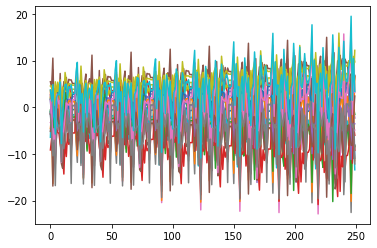

In [22]:
i = 1
for images, labels in test_loader:
    if i ==1 :
        images = images.view(-1, seq_dim, input_dim).to(device)


        outputs, _,_,output_mem = model(images)
        output_mem = np.array(output_mem).reshape(batch_size,250, 400)

        for i in range(20):
            plt.plot(output_mem[1,:, i], label=str(i))
        # plt.legend()
        plt.show()
    else:
        break


In [31]:
i = 1
spike_count = {'total':[],'fr':[],'per step':[]}
for images, labels in test_loader:
    if i>0 :
        i+=1
        images = images.view(-1, seq_dim, input_dim).to(device)

        outputs, spike1,_,spike2 = model(images)
        b = images.shape[0]
        spike1 = np.array(spike1).reshape(b,250, 400)
        spike2 = np.array(spike2).reshape(b,250, 400)
        spikes = np.zeros((b,250,800))
        spikes[:,:,:400] = spike1
        spikes[:,:,400:] = spike2
        sum_spike= np.sum(spikes,axis=(1,2))
        spike_count['total'].append([np.mean(sum_spike),np.max(sum_spike),np.min(sum_spike)])
        spike_count['fr'].append(np.mean(spikes))
        spike_count['per step'].append([np.mean(np.sum(spikes,axis=(2))),np.max(np.sum(spikes,axis=(2))),np.min(np.sum(spikes,axis=(2)))])
        
    # else:
    #     break


In [34]:
spike_total_npy = np.array(spike_count['total'])
np.mean(spike_total_npy[0,:]),np.max(spike_total_npy[1,:]),np.min(spike_total_npy[2,:])

(5442.989583333333, 8134.0, 1316.0)

In [36]:
spike_total_npy = np.array(spike_count['fr'])
np.mean(spike_total_npy)

0.02884484473116169

In [37]:
spike_total_npy = np.array(spike_count['per step'])
np.mean(spike_total_npy[0,:]),np.max(spike_total_npy[1,:]),np.min(spike_total_npy[2,:])

(34.994625, 83.0, 0.0)